In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn. neighbors import LocalOutlierFactor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import expon, reciprocal
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier
from missingpy import MissForest

import warnings
warnings.filterwarnings('ignore')

### (Kaggle) Feature Engineering and Feature Selection
- https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection
- feature selection 방법들 성능 비교 실험
    - https://www.kaggle.com/harangdev/feature-selection

In [209]:
df0 = pd.read_csv('./data/galaxy_shotgun.csv', index_col=0)
df = pd.read_csv('./data/galaxy_final.csv', index_col=0)

In [210]:
df

,index,BuyItNow,startprice,productSeries_imputed,product_isNote_imputed,hasDescription,charCountDescriptionBins,upperCaseDescription_rate,startprice_point9,sold,color_sentiment_0,color_sentiment_1,carrier_none_0,carrier_none_1
0,0,0,199.99,2,0,0,0,0.000000,1,1,1,0,0,1
1,1,0,235.00,2,1,0,0,0.000000,0,0,0,0,0,1
2,2,0,199.99,1,0,1,1,0.020000,1,0,0,0,0,0
3,3,1,175.00,2,1,0,0,0.000000,0,1,0,1,1,0
4,4,1,100.00,1,0,0,0,0.000000,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,1480,0,89.50,0,0,1,1,0.020833,0,0,0,0,1,0
1481,1481,0,239.95,2,0,1,1,0.051546,1,1,0,1,0,1
1482,1482,0,329.99,3,1,1,1,0.010753,1,0,0,1,0,1
1483,1483,0,89.00,0,0,1,1,0.021739,0,1,0,1,0,1


In [29]:
X0 = df0.drop(['sold', 'carrier','color', 'startprice_standardized',
             'startprice_minmax', 'noDescription', 'productline',
             'productline_imputed', 'productline_imputed2'], axis=1)
y0 = df0.sold
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=11,
                                                       stratify=y0, shuffle=True)

X = df.drop('sold', axis=1)
y = df.sold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,
                                                       stratify=y, shuffle=True)

# Model Selection

### LIGHTGBM 이란? 그리고 PARAMETER 튜닝하기
- https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/
- http://machinelearningkorea.com/2019/09/29/lightgbm-파라미터/

---
- ask : 데이터에 대해서 수행하고자 하는 임무를 구체화합니다. train 트레이닝일 수도 있고 predict 예측일 수도 있습니다.

- application : 가장 중요한 파라미터로, 모델의 어플리케이션을 정하는데 이것이 regression 회귀분석 문제인지 또는 classification 분류 문제인지를 정합니다. Light GBM에서 디폴트는 regression 회귀분석 모델입니다.
    - regression: 회귀분석
    - binary: 이진 분류
    - multiclass: 다중 분류

- boosting : 실행하고자 하는 알고리즘 타입을 정의합니다. 디폴트값은 gdbt 입니다.
    - gdbt : Traditional Gradient Boosting Decision Tree
    - rf : Random Forest
    - dart : Dropouts meet Multiple Additive Regression Trees
    - goss : Gradient-based One-Side Sampling

- num_boost_round : boosting iteration 수로 일반적으로 100 이상입니다.

- learning_rate : 최종 결과에 대한 각각의 Tree에 영향을 미치는 변수입니다. GBM은 초기의 추정값에서 시작하여 각각의Tree 결과를 사용하여 추정값을 업데이트 합니다. 학습 파라미터는 이러한 추정에서 발생하는 변화의 크기를 컨트롤합니다. 일반적인 값은 0.1, 0.001, 0.003 등등이 있습니다.

- num_leaves : 전체 Tree의 leave 수 이고, 디폴트값은 31입니다.

- device : 디폴트 값은 cpu 인데 gpu로 변경할 수도 있습니다.


- metric : 모델을 구현할 때 손실을 정하기 때문에 중요한 변수 중에 하나입니다. regression과 classification 을 위한 일반적인 손실 값이 아래에 나와있습니다.

    - mae : mean absolute error
    - mse : mean squared error
    - binary_logloss : loss for binary classification
    - multi_logloss : loss for multi classification

- max_bin : feature 값의 최대 bin 수를 의미합니다.
- categorical_feature : 범주형 feature의 인덱스를 의미합니다. 만약 categorical_features 가 0, 1, 2 이면 column 0, column 1, column 2 가 범주형 변수들입니다.
- ignore_column : categorical_features와 동일한 것인데 범주형 feature로써 특정 칼럼을 고려하지 않는 것입니다. 그 변수들을 무시하는 것입니다.
- save_binary : 데이터 파일의 메모리 사이즈를 처리해야 한다면 이 파라미터 값을 True로 설정하십시오. 이 값을 True로 세팅하면 데이터 세트를 바이너리 파일로 저장할 것이고, 이 바이너리 파일은 다음에 데이터를 읽어올 때 그 속도를 줄여줄 것입니다.

In [207]:
pipe = Pipeline([
                ('scale', MinMaxScaler()),
                ('poly', PolynomialFeatures()),
                ('classifier', LGBMClassifier())
                ])

param_grid = [
#                 {'classifier': [LogisticRegression()],
#                'classifier__penalty': ['l1', 'l2'], 
#                'classifier__C': [0.0001, 0.01, 0.1, 1, 100, 1000],
#                'scale': [MinMaxScaler(), StandardScaler(), RobustScaler()],
#                'poly':[PolynomialFeatures()],
#                'poly__degree':[1, 2, 3]
#                },
              
              {'classifier': [LGBMClassifier()],
              'classifier__max_depth': [3, 5, 7, 9],
              'classifier__num_leaves':[2**2-1, 2**4-1, 2**5-1, 2**7-1],
              'classifier__min_child_samples': [10, 15],
              'classifier__subsample': [0.25, 0.5, 0.75, 1],
             'classifier__learning_rate':[0.03, 0.1],
             'classifier__n_estimators':[64, 128, 256],
               'classifier__application':['binary'],
               'classifier__metric':['binary_logloss'],
               'classifier__categorical_feature':[[0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12]],
               'classifier__feature_fraction':[0.7, 0.9, 1],
               'classifier__boosting_type':['gbdt', 'dart'],
               'classifier__num_iterations':[1000, 3000],
               'classifier__drop_rate':[0.1, 0.2, 0.3],
               'scale':[MinMaxScaler(), StandardScaler(), RobustScaler()],
               'poly':[PolynomialFeatures()],
               'poly__degree':[1, 2, 3]
              }
              
#               {'classifier': [Ridge()],
#                'classifier__alpha' : [0.001, 0.01, 0.1, 1, 10, 100],
#                'scale': [MinMaxScaler(), StandardScaler(), RobustScaler()],
#                'poly':[PolynomialFeatures()],
#                'poly__degree':[1, 2, 3]               
#                },
#               {'classifier': [XGBRegressor()],
#               'classifier__learning_rate': [0.001, 0.01, 0.1] ,
#             'classifier__max_depth': [3, 6, 9],
#             'classifier__min_child_weight' : [3, 5, 7],
#             'classifier__gamma'            : [0.1, 0.3, 0.5],
#             'classifier__colsample_bytree' : [0.3, 0.5 , 0.7],
#             'classifier__n_estimators':[64, 256, 1024]
#               }
             
             ] # min_samples_split: The minimum number of samples required to split an internal node       


grid = GridSearchCV(pipe, param_grid, scoring = 'accuracy',
                    cv=StratifiedKFold(n_splits=5),
                    verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 248832 candidates, totalling 1244160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 18.0min


KeyboardInterrupt: 

# SVM Tuning
- [서포트 벡터 머신(SVM)의 사용자로서 꼭 알아야할 것들 - 매개변수 C와 gamma](https://bskyvision.com/163)
    - [SVM model selection – how to adjust all these knobs pt. 1](https://tomaszkacmajor.pl/index.php/2016/04/24/svm-model-selection/)
    - [SVM model selection – how to adjust all these knobs pt. 2](https://tomaszkacmajor.pl/index.php/2016/05/01/svm-model-selection2/)
    - [Data preprocessing for SVM classifier](https://tomaszkacmajor.pl/index.php/2016/04/24/data-preprocessing/)
    
### 차원축소
http://www.datamarket.kr/xe/board_oFxn34/26649

In [135]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=7)),
        ('clf', svm.SVC(kernel = 'linear', C = 0.0001, gamma=0.0001))])

param_grid = dict(reduce_dims__n_components=[7, 9, 11],
                  clf__gamma=[0.0001, 0.1, 1, 100, 1000],
                  #clf__C=np.logspace(-1, 1, 6),
                  clf__C=[0.0001, 0.1, 1, 100, 1000],
                  clf__kernel=['rbf'],
                 scale=[MinMaxScaler(), StandardScaler(), RobustScaler()]
                 )

grid = GridSearchCV(pipe, param_grid=param_grid,
                    cv=StratifiedKFold(n_splits=5),
                    n_jobs=-1, verbose=1, scoring='accuracy')
grid.fit(X_train, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1118 out of 1125 | elapsed:   23.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:   23.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('reduce_dims',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=7, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('clf',
                                        SVC(C=0.0001, break_ties...
                         'clf__gamma': [0.0001, 0.1, 1, 100, 1000],
                         'clf__kernel': ['rbf'],
            

In [136]:
print(grid.best_score_)
print(grid.best_params_)

0.7845335602595468
{'clf__C': 1, 'clf__gamma': 1, 'clf__kernel': 'rbf', 'reduce_dims__n_components': 7, 'scale': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)}


### SVC with Dimension Reduction
- PCA & LDA
    - https://huidea.tistory.com/126
- LDA
    - https://yamalab.tistory.com/41
    - http://www.datamarket.kr/xe/board_oFxn34/26649
- TSNE
    - https://agiantmind.tistory.com/215
    - https://lovit.github.io/nlp/representation/2018/09/28/tsne/

In [202]:
pipe2 = Pipeline([
        ('scale', MinMaxScaler()),
        #('poly', PolynomialFeatures()),
        ('reduce_dims', PCA(n_components=5)),
        ('clf', svm.SVC(kernel = 'rbf', C = 0.0001, gamma=0.0001))])

param_grid2 = dict(clf__gamma=[0.0001, 0.001, 0.1, 1, 10, 100, 1000, 10000],
                  clf__C=[0.0001, 0.001, 0.1, 1, 10, 100, 1000, 10000],
                  clf__kernel=['rbf'],
                  reduce_dims = [PCA(), LDA(), TSNE()],
                  reduce_dims__n_components = [5, 7, 9, 11],
                  scale = [MinMaxScaler(), StandardScaler(), RobustScaler()],
                  #poly = [PolynomialFeatures()],
                  #poly__degree = [1, 2, 3],
                  # reduce_dims__n_components=[7, 9, 11]
                  )

grid2 = GridSearchCV(pipe2, param_grid=param_grid2,
                    cv=StratifiedKFold(n_splits=5),
                    n_jobs=-1, verbose=1, scoring='accuracy')
grid2.fit(X_train, y_train)
print(grid2.best_score_)
print(grid2.best_params_)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 4544 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 7344 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 9297 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 10687 tasks      | elapsed: 12.0min


0.7895897599546148
{'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'reduce_dims': PCA(copy=True, iterated_power='auto', n_components=11, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'reduce_dims__n_components': 11, 'scale': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)}


[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed: 36.6min finished


# XGBoost Tuning
- https://www.kaggle.com/lifesailor/xgboost
- https://brunch.co.kr/@snobberys/137
- https://xzz201920.medium.com/xgbosst-booster-gbtree-v-s-dart-v-s-gblinear-82d8fcbb07d2

General Parameter
- booster: tree 기반 모델 / 선형 모델
    - https://xzz201920.medium.com/xgbosst-booster-gbtree-v-s-dart-v-s-gblinear-82d8fcbb07d2
    - skip_drop(default = 0, range [0, 1]) is the probability of skipping dropout. It has a higher priority than other DART parameters.
        - If skip_drop = 1, the dropout procedure would be skipped and dart is the same as gbtree.
    - If skip_drop≠0, rate_drop (default = 0, range [0, 1]) will drop a fraction of the trees before the model update in every iteration.
        - dropout makes dart between gbtree and random forest: “If no tree is dropped, dart is the same as (gbtree); if all the trees are dropped, dart is no different than random forest.”
- silent: 메세지 조절
- nthread: 병렬 처리 조절

Boost Parameter
- eta: Learning rate(일반적으로 0.01 - 0.2)
- min_child_weight: min_child_weight를 기준으로 추가 분기 결정(크면 Underfitting)
- max_depth: Tree 깊이 수
- max_leaf_node: 하나의 트리에서 node 개수
- gamma: split 하기 위한 최소의 loss 감소 정의
- subsample: 데이터 중 샘플링(0.5 - 1)
- colsample_bytree: column 중 sampling(0.5 - 1)
- colsample_bylevel: 각 level마다 샘플링 비율
- lambda: L2 nrom
- alpha: L1 norm
- scale_pos_weight: positive, negative weight 지정
- 기타 등

Learning Task Parameter
- object: 목적함수 종류
    - binary:logistic(이진 분류)
    - multi:softmax(다중 분류)
    - multi-softprob(다중 확률)
- eval_metric: 평가 지표
    - rmse – root mean square error
    - mae – mean absolute error
    - logloss – negative log-likelihood
    - error – Binary classification error rate (0.5 threshold)
    - merror – Multiclass classification error rate
    - mlogloss – Multiclass logloss
    - auc: Area under the curve
seed

### 1. Overview
- high learning rate(0.05 - 0.3)를 선택하고 이 학습률에 맞는 tree 개수를 선정한다.
- tree-specific parameter를 수정한다.
- max_depth, min_child_weight, gamma, subsample, colsample_bytree
- regularization parameter를 수정한다.
- 학습률을 낮추고 다시 반복한다.

### 2. Learning rate와 estimator 수를 고정한다.
초기값은 다음과 같이 선정한다.
- max_depth = 5: 보통 4-6 를 시작점으로 한다.
- min_child_weight = 1 : 향후에 튜닝할 것이다.
- gamma = 0 : 0.1 - 0.2로 시작해도 된다. 그런데 어짜피 튜닝할 것이다.
- subsample, colsample_bytree = 0.8 : 보통 0.5 - 0.9로 시작한다.
- scale_pos_weight = 1: Because of high class imbalance.



In [147]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

def modelfit(alg, dtrain, predictors, useTrainCV=True,
             cv_folds=5, early_stopping_rounds=100):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['sold'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics='error',
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(alg)

    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['sold'], eval_metric='error')

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print("\nModel Report")
    print("Training Accuracy : %.4g" % accuracy_score(dtrain['sold'].values, dtrain_predictions))

In [154]:
xgb1 = XGBClassifier(
            booster='dart',
            rate_drop = 0.15,
            skip_drop = 0.33,
            learning_rate =0.1,
            n_estimators=1000,
            max_depth=5,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective= 'binary:logistic',
            nthread=-1,
            scale_pos_weight=1,
            seed=2021,
            eval_metric='error',
            n_jobs=-1
)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
predictors = X.columns
target='sold'

modelfit(xgb1, train, predictors)

XGBClassifier(base_score=None, booster='dart', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8, eval_metric='error',
              gamma=0, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.1,
              max_delta_step=None, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=29, n_jobs=-1, nthread=-1,
              num_parallel_tree=None, objective='binary:logistic',
              random_state=None, rate_drop=0.15, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=1, seed=2021, skip_drop=0.33,
              subsample=0.8, tree_method=None, ...)

Model Report
Training Accuracy : 0.867


In [155]:
# 3-2. max_depth와 min_child_weight를 튜닝한다.
param_test1 = {
 'max_depth':range(3,10,3),
 'min_child_weight':range(1,6,2)
}

xgb2 = XGBClassifier(
    booster='dart',
    rate_drop = 0.15,
    skip_drop = 0.33,
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=2021,
    eval_metric='error',
    n_jobs=-1
)

gsearch1 = GridSearchCV(estimator = xgb2,
            param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=5, verbose=10)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed:  8.1min remaining:   22.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  8.4min finished


({'mean_fit_time': array([30.58934498, 26.42062712, 25.18061647, 58.34102116, 47.69806466,
         44.90624127, 60.17272582, 54.32366462, 43.40523605]),
  'std_fit_time': array([2.16856498, 0.30750746, 1.00604332, 7.35398565, 3.67966623,
         4.37471127, 3.27167035, 0.56225405, 7.28937719]),
  'mean_score_time': array([0.0107101 , 0.01260343, 0.01409593, 0.03038502, 0.02099056,
         0.02123394, 0.01570101, 0.02136602, 0.01830039]),
  'std_score_time': array([0.00365702, 0.00747294, 0.00694314, 0.02041759, 0.01062081,
         0.00558782, 0.007697  , 0.00872516, 0.00948646]),
  'param_max_depth': masked_array(data=[3, 3, 3, 6, 6, 6, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5],
               mask=[False, False, False, False, False, False, False, False,
                     False],


In [157]:
# Gamma를 튜닝한다.
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

xgb3 = XGBClassifier(
    booster='dart',
    rate_drop = 0.15,
    skip_drop = 0.33,
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=gsearch1.best_params_['max_depth'],
    min_child_weight=gsearch1.best_params_['min_child_weight'],
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=2021,
    eval_metric='error',
    n_jobs=-1
)

gsearch2 = GridSearchCV(estimator = xgb3, 
                        param_grid = param_test2, scoring='accuracy', n_jobs=-1, iid=False, cv=5,
                       verbose=10)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:  3.3min remaining:   37.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.4min finished


({'mean_fit_time': array([28.2780972 , 31.38163762, 30.85981946, 36.53439283, 30.77492914]),
  'std_fit_time': array([ 1.81179902,  0.96373577,  0.83148362,  1.8792291 , 10.35071724]),
  'mean_score_time': array([0.0116014 , 0.00939274, 0.01473279, 0.01874571, 0.0106421 ]),
  'std_score_time': array([0.00439288, 0.00466556, 0.00877517, 0.0054828 , 0.00736782]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.75630252, 0.75210084, 0.7605042 , 0.74789916, 0.75630252]),
  'split1_test_score': array([0.79831933, 0.78991597, 0.78991597, 0.78991597, 0.78991597]),
  'split2_test_score': array([0.84453782, 0.85294118, 0.84453782, 0.8487395 , 0.86134454]),
  'split3_test_score': array([0.82700422, 0.8185654 , 0.82278481, 0.8185654 , 0.8

In [158]:
# subsample and colsample_bytree를 튜닝한다.
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb4 = XGBClassifier(
    booster='dart',
    rate_drop = 0.15,
    skip_drop = 0.33,
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=gsearch1.best_params_['max_depth'],
    min_child_weight=gsearch1.best_params_['min_child_weight'],
    gamma=gsearch2.best_params_['gamma'],
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=2021,
    eval_metric='error',
    n_jobs=-1
)

gsearch3 = GridSearchCV(estimator = xgb4, 
                        param_grid = param_test3, scoring='accuracy', n_jobs=-1, iid=False, cv=5,
                        verbose=10)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  9.3min finished


({'mean_fit_time': array([33.82177029, 27.43664093, 29.60986733, 27.15421758, 26.78870983,
         27.44742198, 26.73164172, 26.73464518, 27.23633585, 27.87654881,
         26.71983852, 26.95309052, 26.97949748, 27.14402366, 28.2483561 ,
         26.60740142]),
  'std_fit_time': array([3.45649065, 0.55654223, 1.14974675, 1.76239089, 0.52037888,
         0.69689367, 0.15469292, 0.25769962, 0.84760538, 1.05114453,
         0.33462508, 0.22678736, 0.27065149, 0.09254482, 0.64694361,
         1.09447646]),
  'mean_score_time': array([0.0103168 , 0.00940862, 0.00755582, 0.01154146, 0.02856846,
         0.01346722, 0.01066875, 0.01021867, 0.0196106 , 0.01529942,
         0.01425109, 0.01114831, 0.01749063, 0.01442151, 0.0139523 ,
         0.01209106]),
  'std_score_time': array([0.00379985, 0.00434638, 0.00151714, 0.00414223, 0.03022814,
         0.00816379, 0.00588096, 0.00446716, 0.01243698, 0.00205384,
         0.00527306, 0.00443785, 0.00633983, 0.00665586, 0.00645169,
         0.006666

In [161]:
# subsample 추가 튜닝하기
param_test4 = {
 'subsample':[i/100.0 for i in range(40,80)],
}

xgb5 = XGBClassifier(
    booster='dart',
    rate_drop = 0.15,
    skip_drop = 0.33,
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=gsearch1.best_params_['max_depth'],
    min_child_weight=gsearch1.best_params_['min_child_weight'],
    gamma=gsearch2.best_params_['gamma'],
    subsample = gsearch3.best_params_['subsample'],
    colsample_bytree = gsearch3.best_params_['colsample_bytree'],
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=2021,
    eval_metric='error',
    n_jobs=-1
)

gsearch4 = GridSearchCV(estimator = xgb5, 
                        param_grid = param_test4, scoring='accuracy', n_jobs=-1, iid=False, cv=5, verbose=10)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 20

({'mean_fit_time': array([34.16247606, 31.28990359, 26.64116697, 26.9349206 , 28.7762085 ,
         27.89253793, 26.6632978 , 26.99618554, 26.8220046 , 27.01053514,
         27.07244186, 27.09902201, 27.15127153, 30.02572675, 27.03914719,
         27.19464259, 27.06251578, 27.11299314, 28.06475592, 29.10566425,
         27.01947479, 28.29517817, 28.12519827, 27.12882376, 28.37538166,
         29.02653737, 28.06477461, 27.44469957, 27.54322405, 27.97695613,
         27.09098935, 27.23149252, 29.90352783, 31.45380397, 27.02714095,
         27.02406144, 27.05721059, 27.87606454, 27.30807614, 25.6852428 ]),
  'std_fit_time': array([0.36247109, 4.24939446, 0.11956619, 0.22758661, 0.56526648,
         1.06494894, 0.27992595, 0.21022993, 0.3087095 , 0.23002698,
         0.11252408, 0.33918324, 0.6015456 , 1.08983461, 0.19628117,
         0.30900045, 0.20727302, 0.22359157, 1.00758749, 0.91349401,
         0.27838073, 1.44648095, 1.16555307, 0.20835624, 2.00616307,
         1.92831982, 0.72690

In [162]:
# rate_drop, skip_drop 튜닝
param_test5 = {
 'rate_drop':[0.1, 0.3, 0.5],
 'skip_drop':[0.1, 0.3, 0.5]
}

xgb6 = XGBClassifier(
    booster='dart',
    rate_drop = 0.15,
    skip_drop = 0.33,
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=gsearch1.best_params_['max_depth'],
    min_child_weight=gsearch1.best_params_['min_child_weight'],
    gamma=gsearch2.best_params_['gamma'],
    subsample = gsearch4.best_params_['subsample'],
    colsample_bytree = gsearch3.best_params_['colsample_bytree'],
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=2021,
    eval_metric='error',
    n_jobs=-1
)

gsearch5 = GridSearchCV(estimator = xgb6, 
                        param_grid = param_test5, scoring='accuracy', n_jobs=-1, iid=False, cv=5, verbose=10)
gsearch5.fit(train[predictors],train[target])
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed:  6.3min remaining:   17.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  6.4min finished


({'mean_fit_time': array([35.01343803, 33.06451864, 31.87412405, 35.17728953, 36.13262448,
         33.11790128, 35.83645515, 34.51584997, 29.00652962]),
  'std_fit_time': array([0.96853782, 4.27064355, 3.26566248, 0.49522371, 1.71216269,
         1.92138669, 1.17391731, 0.48228308, 8.25062032]),
  'mean_score_time': array([0.01449032, 0.0130919 , 0.01246939, 0.0113853 , 0.01552682,
         0.01442266, 0.03317804, 0.01397858, 0.01491027]),
  'std_score_time': array([0.00787979, 0.00576964, 0.00328633, 0.00646876, 0.01004251,
         0.00922464, 0.02024737, 0.00617497, 0.00756098]),
  'param_rate_drop': masked_array(data=[0.1, 0.1, 0.1, 0.3, 0.3, 0.3, 0.5, 0.5, 0.5],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_skip_drop': masked_array(data=[0.1, 0.3, 0.5, 0.1, 0.3, 0.5, 0.1, 0.3, 0.5],
               mask=[False, False, False, False, False, False, False, False,


In [170]:
# Learning Rate 감소
xgb7 = XGBClassifier(
    booster='dart',
    rate_drop = gsearch5.best_params_['rate_drop'],
    skip_drop = gsearch5.best_params_['skip_drop'],
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=gsearch1.best_params_['max_depth'],
    min_child_weight=gsearch1.best_params_['min_child_weight'],
    gamma=gsearch2.best_params_['gamma'],
    subsample = gsearch4.best_params_['subsample'],
    colsample_bytree = gsearch3.best_params_['colsample_bytree'],
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=2021,
    eval_metric='error',
    n_jobs=-1
)
modelfit(xgb7, train, predictors)

XGBClassifier(base_score=None, booster='dart', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.9, eval_metric='error',
              gamma=0.4, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.1,
              max_delta_step=None, max_depth=3, min_child_weight=5, missing=nan,
              monotone_constraints=None, n_estimators=60, n_jobs=-1, nthread=-1,
              num_parallel_tree=None, objective='binary:logistic',
              random_state=None, rate_drop=0.1, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=1, seed=2021, skip_drop=0.5, subsample=0.74,
              tree_method=None, ...)

Model Report
Training Accuracy : 0.8274


In [171]:
# learning rate, scaler 테스트
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', XGBClassifier())])

xgb7 = XGBClassifier(
    booster='dart',
    rate_drop = gsearch5.best_params_['rate_drop'],
    skip_drop = gsearch5.best_params_['skip_drop'],
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=gsearch1.best_params_['max_depth'],
    min_child_weight=gsearch1.best_params_['min_child_weight'],
    gamma=gsearch2.best_params_['gamma'],
    subsample = gsearch4.best_params_['subsample'],
    colsample_bytree = gsearch3.best_params_['colsample_bytree'],
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=2021,
    eval_metric='error',
    n_jobs=-1
)

param_grid = dict(clf=[xgb7],
                  clf__learning_rate=[0.01, 0.03, 0.05, 0.1],
                 scale=[MinMaxScaler(), StandardScaler(), RobustScaler()]
                 )

grid = GridSearchCV(pipe, param_grid=param_grid,
                    cv=StratifiedKFold(n_splits=5),
                    n_jobs=-1, verbose=1, scoring='accuracy')
grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type...
                  

In [182]:
grid.best_score_, grid.best_params_

(0.8123036556394709,
 {'clf': XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.9, eval_metric='error',
                gamma=0.4, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.1, max_delta_step=0,
                max_depth=3, min_child_weight=5, missing=nan,
                monotone_constraints='()', n_estimators=1000, n_jobs=-1,
                nthread=-1, num_parallel_tree=1, objective='binary:logistic',
                random_state=2021, rate_drop=0.1, reg_alpha=0, reg_lambda=1,
                scale_pos_weight=1, seed=2021, skip_drop=0.5, subsample=0.74,
                tree_method='exact', ...),
  'clf__learning_rate': 0.1,
  'scale': StandardScaler(copy=True, with_mean=True, with_std=True)})

# 변수 스케일링 및 분포 변환

모델의 성능을 높이기 위해 변수의 분포를 변환시키나 스케일을 조정하는 등 전처리 과정을 반복적으로 진행할 필요가 있다. 모델 특성 및 데이터 특성 등에 따라 적합한 전처리 과정이 다르므로 여러 번의 시도를 통해 모델의 성능을 올릴 필요가 있다.

- (스케일링) Standardization, Mean Normalizatoin, MinMax Scaling
- (분포변환) Log, Sqrt, Sqaure for distribution transformation

In [ ]:
# pass

# Feature Selection

### RandomForest GridSearch

In [59]:
def test_rf(X_train, y_train, X_test, y_test, p, cv_):
    params = p
    rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
    grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=cv_, n_jobs=-1, verbose=3,
                          scoring='accuracy')
    grid_cv.fit(X_train, y_train)

    pred = grid_cv.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print(accuracy)
    return grid_cv

def show_feature_importances(grid_cv):
    ftr_importances_values = grid_cv.best_estimator_.feature_importances_
    ftr_importances_values = pd.Series(ftr_importances_values, index=X_train.columns)

    ftr_top20 = ftr_importances_values.sort_values(ascending=False)[:20]
    plt.figure(figsize=(8,6))
    plt.title('feature importance top 20')
    sns.barplot(x=ftr_top20, y=ftr_top20.index)
    plt.show()

In [60]:
params = {
    'n_estimators':[50, 100, 150],
    'criterion':['gini', 'entropy'],
    'max_depth':[8, 12, 16],
    'min_samples_leaf':[4, 8, 12],
    'min_samples_split':[4, 8, 12]
}

X_rf_grid = test_rf(X_train, y_train, X_test, y_test,
                      params, StratifiedKFold(n_splits=5))

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  1.5min finished


0.835016835016835


In [61]:
X_rf_grid.best_params_, X_rf_grid.best_score_

({'criterion': 'gini',
  'max_depth': 12,
  'min_samples_leaf': 4,
  'min_samples_split': 4,
  'n_estimators': 150},
 0.808931673935397)

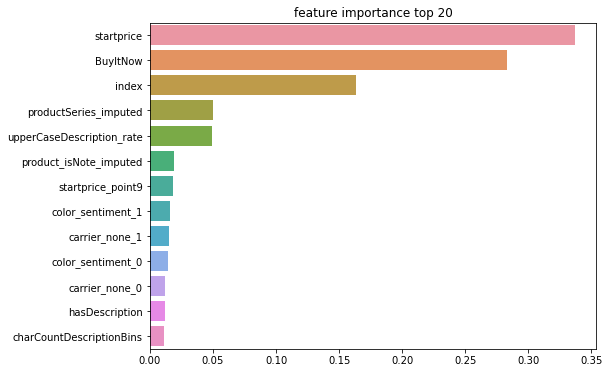

In [62]:
show_feature_importances(X_rf_grid)

In [58]:
from sklearn.ensemble import ExtraTreesClassifier

etc_model = ExtraTreesClassifier()
etc_model.fit(X, y)

print(etc_model.feature_importances_)
feature_list = pd.concat([pd.Series(X.columns), pd.Series(etc_model.feature_importances_)], axis=1)
feature_list.columns = ['features_name', 'importance']
feature_list.sort_values("importance", ascending =False)[:13]

[0.19895018 0.23881906 0.25569496 0.07129039 0.02716665 0.01943401
 0.01516192 0.05276086 0.02846111 0.02285385 0.02240358 0.02197045
 0.02503298]


,features_name,importance
2,startprice,0.255695
1,BuyItNow,0.238819
0,index,0.198950
3,productSeries_imputed,0.071290
7,upperCaseDescription_rate,0.052761
8,startprice_point9,0.028461
4,product_isNote_imputed,0.027167
12,carrier_none_1,0.025033
9,color_sentiment_0,0.022854
10,color_sentiment_1,0.022404


# RFE

In [56]:
model = LogisticRegression()
rfe = RFE(model, 5)
fit = rfe.fit(X, y)

print(f"Num Features: {fit.n_features_}")
print(f"Selected features: {X.columns[fit.support_]}")
print(f"Feature Ranking: {fit.ranking_}")

Num Features: 5
Selected features: Index(['BuyItNow', 'upperCaseDescription_rate', 'color_sentiment_0',
       'carrier_none_0', 'carrier_none_1'],
      dtype='object')
Feature Ranking: [9 1 8 6 7 5 2 1 3 1 4 1 1]


/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

In [64]:
model = RandomForestClassifier()
rfe = RFE(model, 5)
fit = rfe.fit(X, y)

print(f"Num Features: {fit.n_features_}")
print(f"Selected features: {X.columns[fit.support_]}")
print(f"Feature Ranking: {fit.ranking_}")

Num Features: 5
Selected features: Index(['index', 'BuyItNow', 'startprice', 'productSeries_imputed',
       'upperCaseDescription_rate'],
      dtype='object')
Feature Ranking: [1 1 1 1 2 8 9 1 5 6 4 7 3]


# Sequential Feature Selector

In [75]:
# Install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector
selector = SequentialFeatureSelector(LogisticRegression(), scoring='neg_log_loss', 
                                     verbose=2, k_features=10, forward=False, n_jobs=-1)
selector.fit(X_train, y_train)

/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

SequentialFeatureSelector(clone_estimator=True, cv=5,
                          estimator=LogisticRegression(C=1.0, class_weight=None,
                                                       dual=False,
                                                       fit_intercept=True,
                                                       intercept_scaling=1,
                                                       l1_ratio=None,
                                                       max_iter=100,
                                                       multi_class='auto',
                                                       n_jobs=None,
                                                       penalty='l2',
                                                       random_state=None,
                                                       solver='lbfgs',
                                                       tol=0.0001, verbose=0,
                                                       warm_start=False),

In [76]:
selector.k_feature_names_

('index',
 'BuyItNow',
 'startprice',
 'productSeries_imputed',
 'product_isNote_imputed',
 'hasDescription',
 'startprice_point9',
 'color_sentiment_1',
 'carrier_none_0',
 'carrier_none_1')

### Local Outlier Factor
- The number of neighbors considered (parameter n_neighbors) is typically set 
    - 1) greater than the minimum number of samples a cluster has to contain, so that other samples can be local outliers relative to this cluster
    - 2) smaller than the maximum number of close by samples that can potentially be local outliers. 
- In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [205]:
test_neighbors = np.linspace(1, 100, num=20).astype(int)
test_contams = np.linspace(0.01, 0.2, num=20)
best_params, best_acc, X2, y2 = 0, 0, 0, 0

def tune_lof_by_model(model, df, scaler=None, poly=None, dim_reduction=None):
    best_params, best_acc, X2, y2 = 0, 0, 0, 0
    for i, tn in enumerate(test_neighbors):
        print(i, end='/')
        for j, tc in enumerate(test_contams):
            
            clf = LocalOutlierFactor(n_neighbors=tn, contamination=tc)
            y_pred = clf.fit_predict(df.drop('sold', axis=1))
            lof_outlier_idx = pd.Series(y_pred)[pd.Series(y_pred)==-1].index
            df_lof2 = df.drop(lof_outlier_idx)
            
            X2 = df_lof2.drop('sold', axis=1)
            y2 = df_lof2.sold
            X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2,
                                                                    test_size=0.2,
                                                                    shuffle=True,
                                                                    stratify=y2,
                                                                    random_state=11)
            
            if scaler:
                X2_train = scaler.fit_transform(X2_train)
                X2_test = scaler.transform(X2_test)
                
            if poly:
                X2_train = poly.fit_transform(X2_train)
                X2_test = poly.transform(X2_test)
            
            if dim_reduction:
                X2_train = dim_reduction.fit_transform(X2_train)
                X2_test = dim_reduction.transform(X2_test)
            
            mod = model
            mod.fit(X2_train, y2_train)
            mod_acc = accuracy_score(y2_test, mod.predict(X2_test))
            if best_acc < mod_acc:
                best_acc = mod_acc
                best_params = (tn, tc)
                X2 = X2
                y2 = y2
    return best_params, best_acc, X2, y2
        #print(accuracy_score(y2_test, lr.predict(X2_test)))
        #print(test_ensemble(X2_train, y2_train, X2_test, y2_test))

### RandomForest Best Model
```python
LocalOutlierFactor(n_neighbors=10, contamination=0.06999999999999999)
```

> final test acc = 0.866 (before LOF: Grid Best Score 0.809)

```python
rf_best = RandomForestClassifier(random_state=0, n_jobs=-1,
                                criterion='gini', max_depth=12,
                                min_samples_leaf=4, min_samples_split=4,
                                n_estimators=150)
```

In [91]:
rf_best = RandomForestClassifier(random_state=0, n_jobs=-1,
                                criterion='gini', max_depth=12,
                                min_samples_leaf=4, min_samples_split=4,
                                n_estimators=150)
rf_lof_tune = tune_lof_by_model(rf_best, df)
rf_lof_tune[:2]

0/1/2/3/4/5/6/7/8/9/10/11/12/13/14/15/16/17/18/19/20/21/22/23/24/25/26/27/28/29/30/31/32/33/34/35/36/37/38/39/40/41/42/43/44/45/46/47/48/49/50/51/52/53/54/55/56/57/58/59/60/61/62/63/64/65/66/67/68/69/70/71/72/73/74/75/76/77/78/79/80/81/82/83/84/85/86/87/88/89/90/91/92/93/94/95/96/97/98/99/

((10, 0.06999999999999999), 0.8664259927797834)

In [92]:
X_lof_rf = rf_lof_tune[2]
y_lof_rf = rf_lof_tune[3]

### Light GBM Best Model
- Grid Best Score (accuracy, before LOF) = 0.815 (GridCV, StratifiedKFold(n_split=5))

```python
LocalOutlierFactor(n_neighbors=79, contamination=0.05)
```

> Final Test Acc. = 0.843

```python
{'classifier': LGBMClassifier(application='binary', boosting_type='gbdt',
               categorical_feature=[0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12],
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=7, metric='binary_logloss',
               min_child_samples=15, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=128, n_jobs=-1, num_leaves=15, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.25, subsample_for_bin=200000, subsample_freq=0), 'classifier__application': 'binary', 'classifier__categorical_feature': [0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12], 'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__metric': 'binary_logloss', 'classifier__min_child_samples': 15, 'classifier__n_estimators': 128, 'classifier__num_leaves': 15, 'classifier__subsample': 0.25, 'poly': PolynomialFeatures(degree=3, include_bias=True, interaction_only=False,
                   order='C'), 'poly__degree': 3, 'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}
```

In [189]:
lgbm_best = LGBMClassifier(application='binary', boosting_type='gbdt',
               categorical_feature=[0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12],
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=7, metric='binary_logloss',
               min_child_samples=15, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=128, n_jobs=-1, num_leaves=15, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.25, subsample_for_bin=200000, subsample_freq=0)

lgbm_scaler = StandardScaler()
lgbm_poly = PolynomialFeatures(degree=3)
lgbm_lof_tune = tune_lof_by_model(lgbm_best, df,
                                  scaler=lgbm_scaler,
                                 poly=lgbm_poly)
lgbm_lof_tune[:2]

0/1/2/3/4/5/6/7/8/9/10/11/12/13/14/15/16/17/18/19/

((79, 0.05), 0.8439716312056738)

### XGBoost Best Model

```python
LocalOutlierFactor(n_neighbors=11, contamination=0.15)
```

- Grid Best Score (accuracy, before LOF) = 0.812 (GridCV, StratifiedKFold(n_split=5))

> Final Test Acc. = 0.854

```python
xgb7 = XGBClassifier(
    booster='dart',
    rate_drop = 0.1,
    skip_drop = 0.5,
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=3,
    min_child_weight=5,
    gamma=0.4,
    subsample = 0.74,
    colsample_bytree = 0.9,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=2021,
    eval_metric='error',
    n_jobs=-1
)
```

In [190]:
xgb_best = XGBClassifier(
    booster='dart',
    rate_drop = 0.1,
    skip_drop = 0.5,
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=3,
    min_child_weight=5,
    gamma=0.4,
    subsample = 0.74,
    colsample_bytree = 0.9,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=2021,
    eval_metric='error',
    n_jobs=-1
)

xgb_scaler = StandardScaler()
xgb_lof_tune = tune_lof_by_model(xgb_best, df, scaler=xgb_scaler)
xgb_lof_tune[:2]

0/1/2/3/4/5/6/7/8/9/10/11/12/13/14/15/16/17/18/19/

((11, 0.15000000000000002), 0.8537549407114624)

In [166]:
print(gsearch5.best_params_['rate_drop'], gsearch5.best_params_['skip_drop'])
print(gsearch1.best_params_['max_depth'])
print(gsearch1.best_params_['min_child_weight'])
print(gsearch2.best_params_['gamma'])
print(gsearch4.best_params_['subsample'])
print(gsearch3.best_params_['colsample_bytree'])

0.1 0.5
3
5
0.4
0.74
0.9


### Support Vector Machine Best Model
Grid Best Score (accuracy, before LOF) = 0.790 (GridCV, StratifiedKFold(n_split=5))

```python
LocalOutlierFactor(n_neighbors=37, contamination=0.1)
```

> Final Test Acc. 0.848

```python
{'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'reduce_dims': PCA(copy=True, iterated_power='auto', n_components=11, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'reduce_dims__n_components': 11, 'scale': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)}
```

In [206]:
svm_best = svm.SVC(C=10, gamma=0.1, kernel='rbf')
svm_dim_reduction = PCA(n_components=11)
svm_scaler = RobustScaler()

svc_lof_tune = tune_lof_by_model(svm_best, df, scaler=svm_scaler,
                                dim_reduction=svm_dim_reduction)
svc_lof_tune[:2]

0/1/2/3/4/5/6/7/8/9/10/11/12/13/14/15/16/17/18/19/

((37, 0.09999999999999999), 0.8470149253731343)

### Other Models?
- Linear Regression
- Gaussian NB
- ?

In [ ]:
# 재사용할 코드
pipe = Pipeline([
                ('scale', MinMaxScaler()),
                ('poly', PolynomialFeatures()),
                ('classifier', LogisticRegression())
                ])

param_grid = [{'classifier': [LogisticRegression()],
               'classifier__penalty': ['l1', 'l2'], 
               'classifier__C': [0.0001, 0.01, 0.1, 1, 100, 1000],
               'scale': [MinMaxScaler(), StandardScaler(), RobustScaler()],
               'poly':[PolynomialFeatures()],
               'poly__degree':[1, 2, 3]
               },
              
              {'classifier': [LGBMClassifier()],
              'classifier__max_depth': [3, 5, 7],
              'classifier__num_leaves':[2**2-1, 2**4-1, 2**5-1],
              'classifier__min_child_samples': [10, 15],
              'classifier__subsample': [0.25, 0.5, 0.75, 1],
             'classifier__learning_rate':[0.001, 0.005, 0.01],
             'classifier__n_estimators':[32, 64, 128],
               'classifier__application':['binary'],
               'classifier__metric':['binary_logloss'],
               'classifier__categorical_feature':[[0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12]],
               'scale':[MinMaxScaler(), StandardScaler(), RobustScaler()],
               'poly':[PolynomialFeatures()],
               'poly__degree':[1, 2, 3]
              }
              
             ] # min_samples_split: The minimum number of samples required to split an internal node       


grid = GridSearchCV(pipe, param_grid, scoring = 'accuracy',
                    cv=StratifiedKFold(n_splits=5),
                    verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

### GridCV for LogReg

In [ ]:
def test_grid(model, X_train, y_train, X_test, y_test, p):
    params = p
    model = model #RandomForestClassifier(random_state=0, n_jobs=-1)
    grid_cv = GridSearchCV(model, param_grid=params,
                           cv=StratifiedKFold(n_splits=5),
                           n_jobs=-1)
    grid_cv.fit(X_train, y_train)
    pred = grid_cv.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print(accuracy)
    return grid_cv

In [ ]:
logreg_p = {"C":np.logspace(-3, 3, 30),
             "penalty":["l1","l2"],
           "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
           "tol":np.logspace(-6, 1, 30),
           "multi_class":['auto', 'ovr', 'multinomial']
           }
lr = LogisticRegression(multi_class='auto', random_state=0, n_jobs=-1)
logreg_grid = test_grid(lr, X1_train, y1_train, X1_test, y1_test, logreg_p)
logreg_grid.best_params_

In [ ]:
logreg_p = {"C":np.logspace(-3, 3, 30),
             "penalty":["l1","l2"],
           "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
           "tol":np.logspace(-6, 1, 30),
           "multi_class":['auto', 'ovr', 'multinomial']
           }
lr = LogisticRegression(random_state=0, n_jobs=-1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=11)

logreg_grid2 = test_grid(lr, X2_train, y2_train, X2_test, y2_test, logreg_p)
logreg_grid2.best_params_, logreg_grid2.best_score_

### SVM GridSearch
- [서포트 벡터 머신(SVM)의 사용자로서 꼭 알아야할 것들 - 매개변수 C와 gamma](https://bskyvision.com/163)
    - [SVM model selection – how to adjust all these knobs pt. 1](https://tomaszkacmajor.pl/index.php/2016/04/24/svm-model-selection/)
    - [SVM model selection – how to adjust all these knobs pt. 2](https://tomaszkacmajor.pl/index.php/2016/05/01/svm-model-selection2/)
    - [Data preprocessing for SVM classifier](https://tomaszkacmajor.pl/index.php/2016/04/24/data-preprocessing/)

### Light GBM
설명 및 사용법 https://greeksharifa.github.io/machine_learning/2019/12/09/Light-GBM/

# Locally Linear Embedding
출처: https://excelsior-cjh.tistory.com/168?category=918734 [EXCELSIOR]

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

In [ ]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=2, random_state=42, eigen_solver='dense')
lle.fit(X1)
X1_reduced = lle.transform(X1)
plt.title("d", fontsize=14)
plt.scatter(X1_reduced[:, 0], X1_reduced[:, 1], c=y1, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()

### StackingClassifier
https://www.kaggle.com/kabirnagpal/feature-selection-and-stacking-f1-score-99
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html

```python
x_train, x_test, y_train, y_test =\
  train_test_split(cancer.data, cancer.target,
                   random_state=0, test_size=0.3, stratify=cancer.target)
```
- train_test_split, `stratify` 파라미터

In [ ]:
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.naive_bayes import *
from sklearn.svm import *
from sklearn.neighbors import *
from sklearn.tree import *
from sklearn.metrics import *
import time
import warnings

classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="rbf"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    RidgeClassifier(),
    LogisticRegression(max_iter=200)
]
def f_score(X_train, X_test, y_train, y_test):
    for clf in classifiers:
        s = time.time()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        f = f1_score(y_true=y_test,y_pred=y_pred,average="macro")
        e = time.time()
        print(f"Score: {round(f,3)} \t Time(in secs): {round(e-s,3)} \t Classifier: {clf.__class__.__name__}")
    

In [ ]:
f_score(X2_train, X2_test, y2_train, y2_test)

In [ ]:
estimators = [
#        ('RFC' ,RandomForestClassifier(n_estimators=500, random_state = 42)),
#        ('KNC', KNeighborsClassifier(5)),
#        ('DTC', DecisionTreeClassifier()),
#        ('SVC', SVC(kernel="rbf")),
        ('GNB', GaussianNB()),
        ('RC',  RidgeClassifier()),
        ('LR', LogisticRegression(max_iter=200))
]

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=GradientBoostingClassifier()
)

s = time.time()
clf.fit(X2_train,y2_train)
y_pred = clf.predict(X2_test)
e = time.time()
print(f"time consumed: {round(e-s,3)}")
print(accuracy_score(y2_test, y_pred))
print(f1_score(y_true=y2_test,y_pred=y_pred,average="macro"))



# error analysis

In [ ]:
def result_df(grid_cv_fit, X, y):
    
    X_pred = pd.DataFrame(grid_cv_fit.predict(X),
                          columns=['sold_pred'])
    X_pred_proba = pd.DataFrame(grid_cv_fit.predict_proba(X),
                                columns=['sold0_proba', 'sold1_proba'])
    y = pd.DataFrame(y, columns=['sold'])
    
    res_df = pd.concat([X, y, X_pred, X_pred_proba], axis=1)
    res_df['wrong_pred'] = res_df['sold'] != res_df['sold_pred']
    
    return res_df